# Error Detection using LSTMs
This notebook demonstrates how we use record embeddings to perform error detection in tuples. We are using the **Hospital** dataset which has been artificially augmented to contain the following type of errors:
1. The cell values have been shuffled across the columnar axis.
2. 5% of tuples has a cell value assigned to NaN.
3. 10% of the tuples has a cell value misspelt.

By converting each tuple to a space separated string and feeding it to an LSTM, we see if the network can learn to detect errors in the tuples.

In [209]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import h5py
import pickle
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from keras import optimizers
from keras import activations
from keras import losses
from keras import metrics

import matplotlib.pyplot as plt
%matplotlib inline

## Read the data

In [210]:
df = pd.read_csv('DirtyHospitalDataset.csv', encoding='utf8')

In [211]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,State,ZipCode,CountyName,PhoneNumber,HospitalType,label
0,10022.0,CHEROKEE MEDICAL CENTER,400 NORTHWOOD DR,CENTRE,AL,35960.0,CHEROKEE,2.569276e+09,Acute Care Hospitals,0.0
1,10011.0,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235.0,JEFFERSON,2.058383e+09,Acute Care Hospitals,1.0


In [212]:
len(df)

2100

In [213]:
df['label'].value_counts()

0.0    1100
1.0    1000
Name: label, dtype: int64

### Some preprocessing to replace phoneNumber and providerNumber with a 0 instead of NaN

In [214]:
df['PhoneNumber'].fillna(0, inplace=True)
df['ProviderNumber'].fillna(0, inplace=True)

In [215]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,State,ZipCode,CountyName,PhoneNumber,HospitalType,label
0,10022.0,CHEROKEE MEDICAL CENTER,400 NORTHWOOD DR,CENTRE,AL,35960.0,CHEROKEE,2.569276e+09,Acute Care Hospitals,0.0
1,10011.0,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235.0,JEFFERSON,2.058383e+09,Acute Care Hospitals,1.0


### Separate the labels from the training data

In [216]:
labels = np.asarray(df['label'].tolist())

In [217]:
df.drop(columns=['label'], axis=1, inplace=True)

In [218]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,State,ZipCode,CountyName,PhoneNumber,HospitalType
0,10022.0,CHEROKEE MEDICAL CENTER,400 NORTHWOOD DR,CENTRE,AL,35960.0,CHEROKEE,2.569276e+09,Acute Care Hospitals
1,10011.0,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235.0,JEFFERSON,2.058383e+09,Acute Care Hospitals


### Drop the HospitalType as it does not add anything new

In [219]:
df.drop(columns=['HospitalType'], axis=1, inplace=True)

In [220]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,State,ZipCode,CountyName,PhoneNumber
0,10022.0,CHEROKEE MEDICAL CENTER,400 NORTHWOOD DR,CENTRE,AL,35960.0,CHEROKEE,2.569276e+09
1,10011.0,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235.0,JEFFERSON,2.058383e+09


### Convert PhoneNumber and ProviderNumber to int

In [221]:
df['ProviderNumber'] = df['ProviderNumber'].apply(lambda x: int(x))
df['PhoneNumber'] = df['PhoneNumber'].apply(lambda x: int(x))

In [222]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,State,ZipCode,CountyName,PhoneNumber
0,10022,CHEROKEE MEDICAL CENTER,400 NORTHWOOD DR,CENTRE,AL,35960.0,CHEROKEE,2569275531
1,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235.0,JEFFERSON,2058383122


### Convert each row to a space separated string

In [223]:
dfList = df.values.tolist()

In [224]:
rows = []
for row in dfList:
    combined = ','.join([str(x) for x in row])
    rows.append(combined)

In [225]:
len(rows)

2100

In [226]:
rows[0]

'10022,CHEROKEE MEDICAL CENTER,400 NORTHWOOD DR,CENTRE,AL,35960.0,CHEROKEE,2569275531'

In [227]:
max([len(r) for r in rows])

110

### Save the dataset

In [228]:
df.to_csv("HospitalTrainingData.csv", encoding='utf8', index=False)

## Tokenize the data

Since the max length of a row is 110, we can set the maxSequenceLength as 110.

In [229]:
maxSequenceLength = 110
maxWords = 2500

In [230]:
tokenizer = Tokenizer(num_words=maxWords, split=',')

In [231]:
tokenizer.fit_on_texts(rows)
sequences = tokenizer.texts_to_sequences(rows)
word_index = tokenizer.word_index

In [232]:
len(word_index)

395

In [233]:
data = pad_sequences(sequences, maxlen=maxSequenceLength)

In [234]:
data.shape

(2100, 110)

In [235]:
labels.shape

(2100,)

## Train test split

In [236]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

In [237]:
data = data[indices]
labels = labels[indices]

In [238]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=22, stratify=labels)

In [239]:
len(X_train), len(y_train)

(1680, 1680)

In [240]:
len(X_test), len(y_test)

(420, 420)

## Model
**Architecture**
* 1 Embedding layer
* 1 Bidirectional LSTM layer
* 1 output layer, _sigmoid_ activation
* Optimizer: Adam (learning rate = 0.01)
* Loss function: Binary crossentropy loss

In [241]:
embeddingDim = 100

In [242]:
model = models.Sequential()
model.add(layers.Embedding(2500, embeddingDim, input_length=maxSequenceLength))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation=activations.sigmoid))
model.compile(optimizer=optimizers.Adam(lr=0.01), loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])

history = model.fit(X_train, y_train,
                    epochs=35,
                    batch_size=32, 
                    validation_split=0.2)

Train on 1344 samples, validate on 336 samples
Epoch 1/35
1344/1344 [==============================] - 17s 12ms/step - loss: 0.6995 - binary_accuracy: 0.5089 - val_loss: 0.6931 - val_binary_accuracy: 0.5149
Epoch 2/35
1344/1344 [==============================] - 14s 10ms/step - loss: 0.6911 - binary_accuracy: 0.5409 - val_loss: 0.6952 - val_binary_accuracy: 0.4851
Epoch 3/35
1344/1344 [==============================] - 14s 11ms/step - loss: 0.6800 - binary_accuracy: 0.5811 - val_loss: 0.7037 - val_binary_accuracy: 0.5179
Epoch 4/35
1344/1344 [==============================] - 14s 11ms/step - loss: 0.6452 - binary_accuracy: 0.6362 - val_loss: 0.6617 - val_binary_accuracy: 0.5565
Epoch 5/35
1344/1344 [==============================] - 14s 10ms/step - loss: 0.5953 - binary_accuracy: 0.6771 - val_loss: 0.6638 - val_binary_accuracy: 0.6399
Epoch 6/35
1344/1344 [==============================] - 14s 10ms/step - loss: 0.5490 - binary_accuracy: 0.7039 - val_loss: 0.5819 - val_binary_accuracy: 

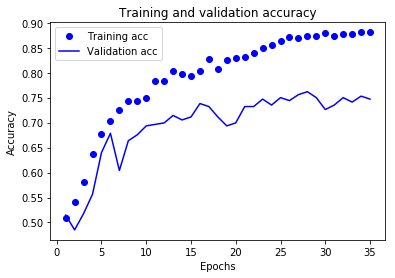

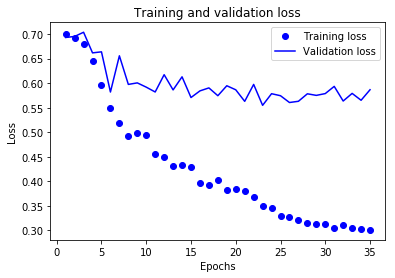

In [243]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

## Evaluation on test set

In [244]:
results = model.evaluate(X_test, y_test)

420/420 [==============================] - 1s 3ms/step


In [245]:
loss = results[0]
accuracy = results[1]

In [246]:
loss

0.550237827144918

In [247]:
accuracy

0.7523809523809524

## Save the model and tokenizer

In [248]:
model.save("HospitalErrorDetectionClassifier.h5")

In [249]:
with open('HospitalErrorDetectionTokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL, fix_imports=True)